<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Production_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from pickle import load

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

import requests
import json

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [32]:
import yfinance as yf
import datetime as dt

limit = 120
end = dt.datetime.now() - dt.timedelta(days=0)
#end = dt.datetime.now() - dt.timedelta(days=1)
start = end - dt.timedelta(days=(limit-1))

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df['date'] = pd.to_datetime(df.index)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,date
Date,,,,,,
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,41083758949,2021-10-12
2021-10-13,56038.257812,57688.660156,54370.972656,57401.097656,41684252783,2021-10-13
2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,36615791366,2021-10-14
2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,51780081801,2021-10-15
2021-10-16,61609.527344,62274.476562,60206.121094,60892.179688,34250964237,2021-10-16
...,...,...,...,...,...,...
2022-02-04,37149.265625,41527.785156,37093.628906,41500.875000,29412210792,2022-02-04
2022-02-05,41501.480469,41847.164062,41038.097656,41441.164062,19652846215,2022-02-05
2022-02-06,41441.121094,42500.785156,41244.906250,42412.433594,16142097334,2022-02-06


In [33]:
response = requests.get("https://api.alternative.me/fng/?limit=" + str(limit))
fear = response.json()
df_fear = pd.json_normalize(fear['data'])
df_fear['date'] = pd.to_datetime(df_fear.timestamp, unit='s')
df_fear = df_fear.set_index(df_fear['date'])
df_fear = df_fear.sort_index().drop(['value_classification','timestamp', 
                                                   'time_until_update', 'date'], axis=1)

df = df.join(df_fear, on='date')
df = df.drop(['date'], axis=1)

In [34]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [36]:
# Model 15 days
days_pred = 15
days_select = 60
date_to_predict = [(end + dt.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1,days_pred+1)]

df_final = df.copy()
df_final = df_final.iloc[-days_select:]
df_rs = np.array(df_final)

scaler = load(open('/content/drive/MyDrive/Trading/15_days/scaler.pkl', 'rb'))
X = scaler.transform(df_rs)
X = np.reshape(X, (1, days_select, 91))

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Trading/15_days/modelo_best.h5')
pred_15 = best_model.predict(X, verbose=1)

1/1 [==============================] - 10s 10s/step


In [37]:
# Model 7 days
days_pred = 7
days_select = 30
date_to_predict = [(end + dt.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1,days_pred+1)]

df_final = df.copy()
df_final = df_final.iloc[-days_select:]
df_rs = np.array(df_final)

scaler = load(open('/content/drive/MyDrive/Trading/7_days/scaler.pkl', 'rb'))
X = scaler.transform(df_rs)
X = np.reshape(X, (1, days_select, 91))

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Trading/7_days/modelo_best.h5')
pred_7 = best_model.predict(X, verbose=1)

1/1 [==============================] - 2s 2s/step


In [38]:
# Model 5 days
days_pred = 5
days_select = 22
date_to_predict = [(end + dt.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1,days_pred+1)]

df_final = df.copy()
df_final = df_final.iloc[-days_select:]
df_rs = np.array(df_final)

scaler = load(open('/content/drive/MyDrive/Trading/5_days/scaler.pkl', 'rb'))
X = scaler.transform(df_rs)
X = np.reshape(X, (1, days_select, 91))

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Trading/5_days/modelo_best.h5')
pred_5 = best_model.predict(X, verbose=1)

1/1 [==============================] - 3s 3s/step


In [39]:
# Model 3 days
days_pred = 3
days_select = 15
date_to_predict = [(end + dt.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1,days_pred+1)]

df_final = df.copy()
df_final = df_final.iloc[-days_select:]
df_rs = np.array(df_final)

scaler = load(open('/content/drive/MyDrive/Trading/3_days/scaler.pkl', 'rb'))
X = scaler.transform(df_rs)
X = np.reshape(X, (1, days_select, 91))

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Trading/3_days/modelo_best.h5')
pred_3 = best_model.predict(X, verbose=1)

1/1 [==============================] - 2s 2s/step


In [40]:
# Model 1 days
days_pred = 1
days_select = 7
date_to_predict = [(end + dt.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1,days_pred+1)]

df_final = df.copy()
df_final = df_final.iloc[-days_select:]
df_rs = np.array(df_final)

scaler = load(open('/content/drive/MyDrive/Trading/1_days/scaler.pkl', 'rb'))
X = scaler.transform(df_rs)
X = np.reshape(X, (1, days_select, 91))

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Trading/1_days/modelo_best.h5')
pred_1 = best_model.predict(X, verbose=1)

1/1 [==============================] - 3s 3s/step


Weighted 7 days prices (Fibonacci)

In [79]:
preds = {'pred_1': pd.Series(pred_1[0]),
         'pred_3': pd.Series(pred_3[0]),
         'pred_5': pd.Series(pred_5[0]),  
         'pred_7': pd.Series(pred_7[0]),
         'pred_15': pd.Series(pred_15[0])}
preds = pd.DataFrame(preds)
preds['pred_7'] = preds['pred_7'].fillna(preds.pred_15)
preds['pred_5'] = preds['pred_5'].fillna(preds.pred_7)
preds['pred_3'] = preds['pred_3'].fillna(preds.pred_5)
preds['pred_1'] = preds['pred_1'].fillna(preds.pred_3)
preds['weighted_pred'] = preds.pred_1*(8/19)+preds.pred_3*(5/19)+preds.pred_5*(3/19)+preds.pred_7*(2/19)+preds.pred_15*(1/19)
preds = preds.iloc[:7]
preds

,pred_1,pred_3,pred_5,pred_7,pred_15,weighted_pred
0,45643.652344,44354.265625,42041.566406,40903.593750,39614.816406,43919.328125
1,44642.437500,44642.437500,42095.640625,40933.906250,39064.609375,43556.371094
2,44688.835938,44688.835938,41962.386719,40846.011719,38436.550781,43524.765625
3,41857.109375,41857.109375,41857.109375,40589.332031,38023.968750,41521.917969
4,41869.105469,41869.105469,41869.105469,40087.582031,37207.781250,41436.246094
5,39835.070312,39835.070312,39835.070312,39835.070312,36440.421875,39656.406250
6,39840.171875,39840.171875,39840.171875,39840.171875,35929.574219,39634.351562


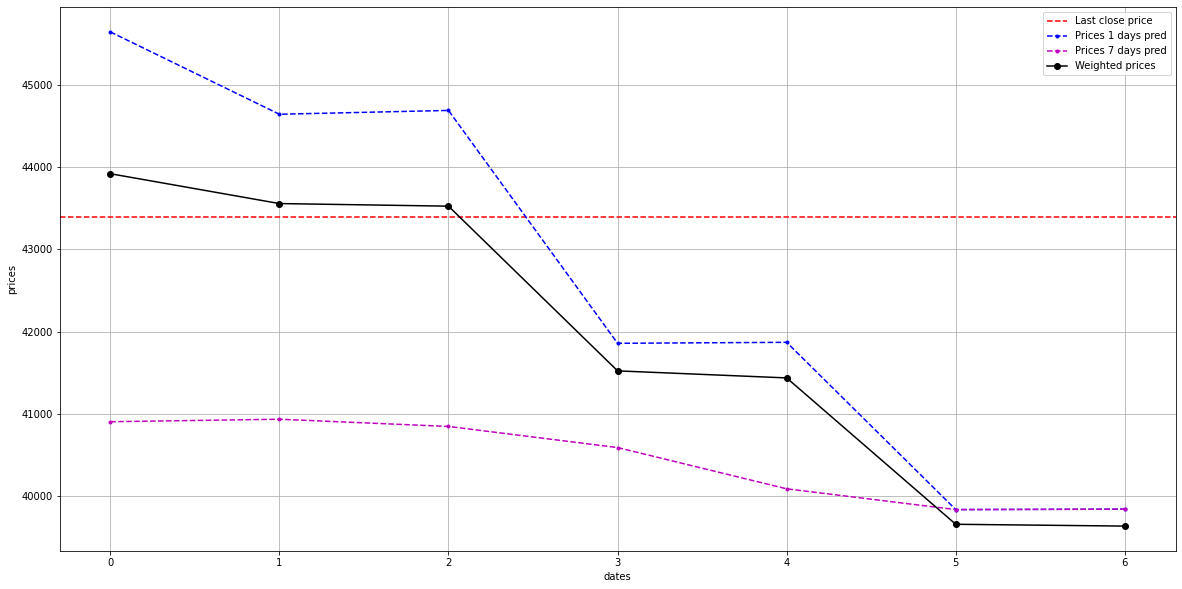

In [80]:
fig=plt.figure(figsize=(20, 10))
plt.axhline(y=df.iloc[-1:].Close.values, label = 'Last close price', color = "r", linestyle='--')
plt.plot(preds.pred_1, '--.', label = 'Prices 1 days pred', color = "b")
#plt.plot(preds.pred_3, '--.', label = 'Prices 3 days pred', color = "g")
#plt.plot(preds.pred_5, '--.', label = 'Prices 5 days pred', color = "brown")
plt.plot(preds.pred_7, '--.', label = 'Prices 7 days pred', color = "m")
#plt.plot(preds.pred_15, '--.', label = 'Prices 15 days pred', color = "y")
plt.plot(preds.weighted_pred.values, '-bo', label = 'Weighted prices', color = "k")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()